# 3 - Stabilité du modèle
Dans ce notebook, nous allons tester la stabilité du modèle afin de déterminer à quel moment, il sera utile de recréer ou de mettre à jour le modèle existant.

Pour mémoire nous avions identifié 4 groupes de clients sur une période de trois mois. Nous allons tester la stabilité sur une période de 12 mois avec un intervalle de 1 mois

![](img/segmentation.png)

# Chargement des bibliothèques

In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns
from olist import Olist
sns.set()
palette = sns.color_palette("bright", 4)

In [2]:
# Nécessaire lors de la phase de développement pour mettre à jour la classe olist dans le notebook
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext pycodestyle_magic
%pycodestyle_on

# Chargement des données

In [5]:
olist = Olist()

# Load dataset
raw_orders = olist.merge_dataset()

# Only delivered orders
orders = raw_orders[raw_orders['order_status'] == 'delivered']

# Filter columns
orders = orders[
    [
        'order_id',
        'customer_unique_id',
        'customer_id',
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        'review_score',
        'payment_value'
    ]
]

# Some data may have an empty delivered date, so drop these rows
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)

# If there is no payment value, the row will be deleted
orders.dropna(subset=['payment_value'], inplace=True)

# Calculate order_purchase_delivered_days
orders['order_purchase_delivered_days'] = (
    orders['order_delivered_customer_date'] -
    orders['order_purchase_timestamp']
).dt.days

# Paramètres

In [6]:
# Selected features
olist.features = [
    'order_purchase_delivered_days',
    'review_score',
    'Frequency',
    'Monetary',
    'Recency'
]

# Previously selected number of cluster
olist.nb_cluster = 4

# Période de référence
La période de référence est de 3 mois, c'est celle qui avait été calculée précédement. Le nombre de clusters avait été fixé à 4. La période du 29/08/2017 au 29/11/2017

In [7]:
purchase_end_date = orders['order_purchase_timestamp'].max()
purchase_start_date = purchase_end_date + relativedelta(months=-12)
purchase_end_date = purchase_start_date + relativedelta(months=3)

print(f"Période de référence du \
{purchase_start_date.strftime('%d/%m/%Y')} au \
{purchase_end_date.strftime('%d/%m/%Y')}")

period_base, kmeans_base = olist.get_period(
    orders,
    purchase_start_date,
    purchase_end_date)
period_base[olist.features].head()

Période de référence du 29/08/2017 au 29/11/2017


,order_purchase_delivered_days,review_score,Frequency,Monetary,Recency
customer_unique_id,,,,,
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,1.0,43.62,47.0
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,1.0,196.89,14.0
00082cbe03e478190aadbea78542e933,10.0,5.0,1.0,126.26,9.0
000bfa1d2f1a41876493be685390d6d3,13.0,4.5,2.0,93.70,61.0
001147e649a7b1afd577e873841632dd,8.0,4.0,2.0,424.32,89.0


# Test de stabilité
Test de stabilité sur une période de 12 mois, à partir de la période de référence on va vérifier la similarité des clusters mois après mois.

In [8]:
# Set base périod
purchase_end_date = orders['order_purchase_timestamp'].max()
purchase_start_date = purchase_end_date + relativedelta(months=-12)
purchase_end_date = purchase_start_date + relativedelta(months=3)
period, kmeans_base = olist.get_period(
    orders,
    purchase_start_date,
    purchase_end_date)

# Set reference period from comparaison
ref_period = period[['cluster']]
ref_period = ref_period.rename(columns={"cluster": "c0"})

In [9]:
periods = []
kmeans = []
new_customers = []
ari = []
ami = []
sankey = []

new_customer_base = period_base.shape[0]

olist.default_cluster = -1

for p in range(4, 13, 1):
    # get period range
    purchase_end_date = orders['order_purchase_timestamp'].max()
    purchase_start_date = purchase_end_date + relativedelta(months=-12)
    purchase_end_date = purchase_start_date + relativedelta(months=p)

    # get clusters
    start_date = purchase_start_date.strftime('%d/%m/%Y')
    end_date = purchase_end_date.strftime('%d/%m/%Y')

    print(f"{p} mois du {start_date} au {end_date}")
    period, kmean = olist.get_period(
        orders,
        purchase_start_date,
        purchase_end_date)

    kmeans.append(kmean)
    periods.append(period)

    # Calculate stability
    period_merged = olist.merge_periods(ref_period, period)
    ARI, AMI = olist.get_scores(period_merged)
    ari.append(ARI)
    ami.append(AMI)
    print(f"\tARI : {ARI:.2f} AMI : {AMI:.2f}")

    # Get new customers difference between periods
    new_customer = period.shape[0] - new_customer_base
    new_customer_base = new_customer
    new_customers.append(new_customer)
    print(f"\t{new_customer} nouveaux clients en 1 mois")

4 mois du 29/08/2017 au 29/12/2017
	ARI : 0.43 AMI : 0.48
	5559 nouveaux clients en 1 mois
5 mois du 29/08/2017 au 29/01/2018
	ARI : 0.32 AMI : 0.42
	22088 nouveaux clients en 1 mois
6 mois du 29/08/2017 au 28/02/2018
	ARI : 0.35 AMI : 0.44
	12343 nouveaux clients en 1 mois
7 mois du 29/08/2017 au 29/03/2018
	ARI : 0.31 AMI : 0.48
	28655 nouveaux clients en 1 mois
8 mois du 29/08/2017 au 29/04/2018
	ARI : 0.30 AMI : 0.45
	19028 nouveaux clients en 1 mois
9 mois du 29/08/2017 au 29/05/2018
	ARI : 0.14 AMI : 0.31
	35164 nouveaux clients en 1 mois
10 mois du 29/08/2017 au 29/06/2018
	ARI : 0.12 AMI : 0.28
	25033 nouveaux clients en 1 mois
11 mois du 29/08/2017 au 29/07/2018
	ARI : 0.10 AMI : 0.26
	40613 nouveaux clients en 1 mois
12 mois du 29/08/2017 au 29/08/2018
	ARI : 0.09 AMI : 0.25
	31838 nouveaux clients en 1 mois


In [10]:
period_merged = olist.merge_periods(ref_period, periods[0])
df = period_merged[['cluster', 'c0', 'review_score']]
df = df[df['c0'] > -1]
df.head()

,cluster,c0,review_score
customer_unique_id,,,
0000f6ccb0745a6a4b88665a16c9f078,0,2.0,4.0
0004aac84e0df4da2b147fca70cf8255,2,0.0,5.0
00082cbe03e478190aadbea78542e933,2,0.0,5.0
000bfa1d2f1a41876493be685390d6d3,0,2.0,4.5
001147e649a7b1afd577e873841632dd,0,2.0,4.0


In [11]:
x = df.groupby(['c0', 'cluster']).agg('count')
x

review_score
c0  cluster              
0.0 0                 793
    1                1538
    2                4004
1.0 0                 425
    1                 182
    3                 803
2.0 0                5783
    1                   3
    2                   8
3.0 1                 742
    2                   1
    3                1289

In [12]:
df.groupby(['c0', 'cluster']).agg('count')['review_score'].values.flatten()

array([ 793, 1538, 4004,  425,  182,  803, 5783,    3,    8,  742,    1,
       1289])

In [13]:
y = df.groupby(['c0', 'cluster']).agg('count')['review_score'].values.flatten()

for group in y:    
    print(group)
    print("r")
    

3:16: W291 trailing whitespace
6:1: W293 blank line contains whitespace
6:1: W391 blank line at end of file


793
r
1538
r
4004
r
425
r
182
r
803
r
5783
r
3
r
8
r
742
r
1
r
1289
r


# Représentation de la stabilité

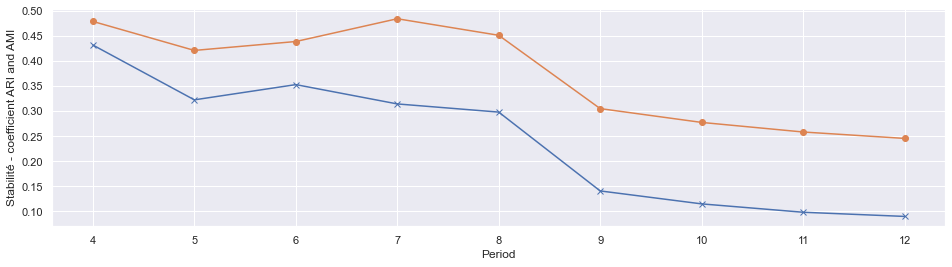

In [14]:
fig = plt.figure(figsize=(16, 4))
plt.plot(range(len(ari)), ari, marker='x')
plt.plot(range(len(ami)), ami, marker='o')
plt.xlabel('Period')
positions = range(9)
labels = range(4, 13)
plt.xticks(positions, labels)
plt.ylabel('Stabilité - coefficient ARI and AMI')
plt.show()

In [15]:
periods[0]['cluster']

customer_unique_id
0000f6ccb0745a6a4b88665a16c9f078    0
0004aac84e0df4da2b147fca70cf8255    2
00082cbe03e478190aadbea78542e933    2
000bfa1d2f1a41876493be685390d6d3    0
000c8bdb58a29e7115cfc257230fb21b    2
                                   ..
fff7219c86179ca6441b8f37823ba3d3    1
fffa431dd3fcdefea4b1777d114144f2    2
fffb09418989a0dbff854a28163e47c6    2
fffbf87b7a1a6fa8b03f081c5f51a201    2
fffea47cd6d3cc0a88bd621562a9d061    1
Name: cluster, Length: 21130, dtype: int64

In [16]:
# data


2:1: W391 blank line at end of file


L'analyse de la stabilité avec les scores ARI et AMI, permete de remarquer que, au bout de 8 mois, le modèle chute drastiquement. On peut en conclure que la période de recalcul se situe à 8 mois.   

# Évolution des nouveaux clients

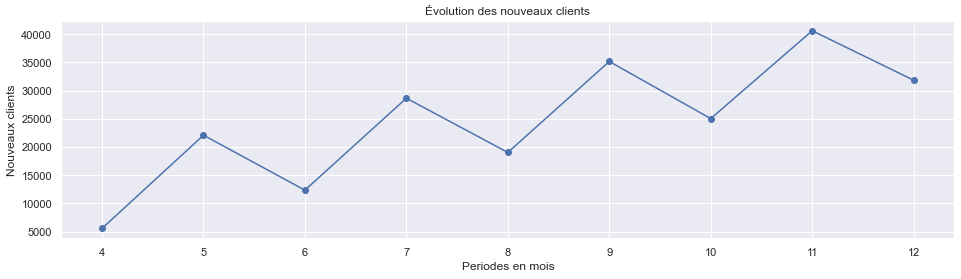

In [17]:
fig = plt.figure(figsize=(16, 4))
plt.plot(range(len(new_customers)), new_customers, marker='o')
plt.xlabel('Periodes en mois')
positions = range(0, 9)
labels = range(4, 13)
plt.xticks(positions, labels)
plt.ylabel('Nouveaux clients')
plt.title("Évolution des nouveaux clients")
plt.show()

Au cours du temps, le nombre de clients évolue, ce qui est à remarquer c'est qu'après chaque augmentation une baisse est établie.

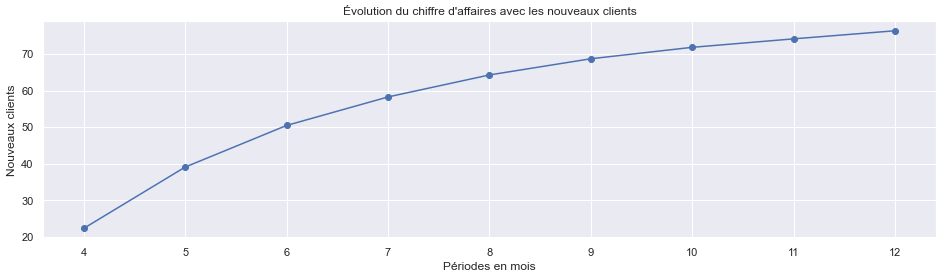

In [18]:
prevenue = []
pcustomer = []

for idx in range(0, 9):
    period_merged = olist.merge_periods(ref_period, periods[idx])

    # % revenue by cluster
    monetary_sum = period_merged['Monetary'].sum()

    clusters = period_merged.groupby('c0').agg({
        'Monetary': 'sum'
    })
    revenue_percent = clusters.groupby(level=0).apply(
        lambda x: 100 * x / monetary_sum)
    prevenue.append(revenue_percent.loc[-1]['Monetary'])

    # % of customer by cluster
    customer_count = period_merged.shape[0]
    customer_percent = (
        period_merged['c0'].value_counts() / customer_count) * 100
    pcustomer.append(customer_percent.loc[-1])

fig = plt.figure(figsize=(16, 4))
plt.plot(range(len(prevenue)), prevenue, marker='o')
plt.xlabel('Périodes en mois')
positions = range(0, 9)
labels = range(4, 13)
plt.xticks(positions, labels)
plt.ylabel('Nouveaux clients')
plt.title("Évolution du chiffre d'affaires avec les nouveaux clients")
plt.show()

On remarque que les nouveaux clients contribuent de plus en plus au chiffre d'affaires de Olist.

# Analyse de la première période (4 mois)

In [19]:
print(f"{new_customers[0]} nouveaux client en 1 mois")

5559 nouveaux client en 1 mois


Text(0.5, 1.0, 'Période de 4 mois')

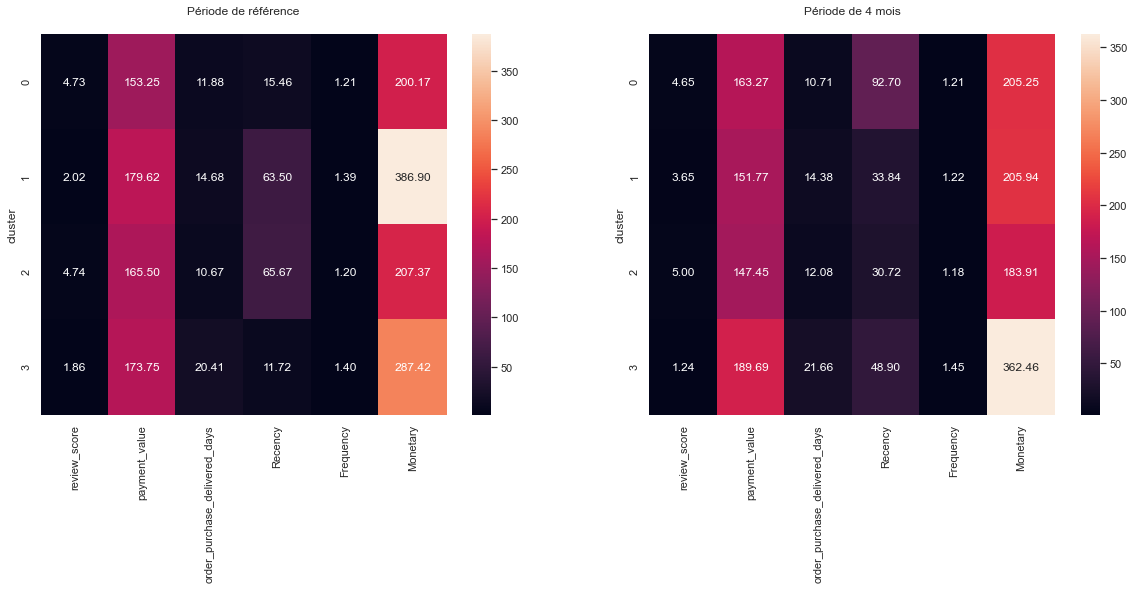

In [20]:
p0 = period_base.groupby('cluster').mean()
p1 = periods[0].groupby('cluster').mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Période de référence', pad=20)

sns.heatmap(data=p1, annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Période de 4 mois', pad=20)

La comparaison avec la première période fait apparaitre peu de variations au niveau des variables : le review score, délai de livraison et de fréquence. La récence montre une augmentation significative pour les groupes 3 et 0, ce qui tend à dire que les petits client contents (groupe 0) vont vers le groupe anciens petits clients (groupe 2), de même que le groupe des clients mécontents (groupe 3) vont vers le groupe des anciens clients mécontents (groupe 1).     

## Répartition des clients

### Période de base

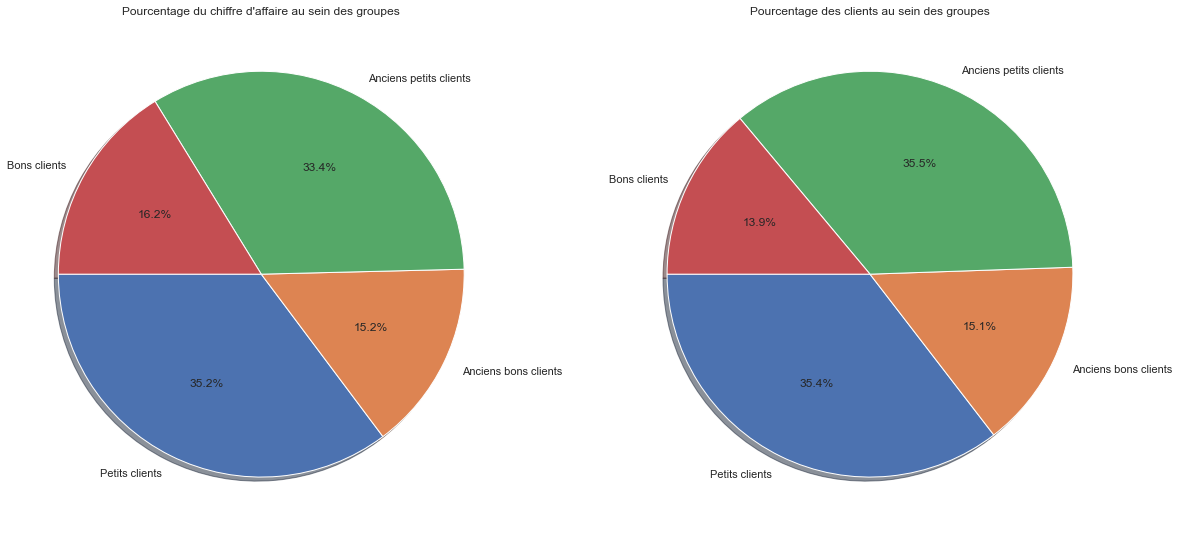

In [21]:
olist.display_customers(
    period_base,
    [
        "Petits clients",
        "Anciens bons clients",
        "Anciens petits clients",
        "Bons clients"
    ],
    'Monetary'
)

### Période de 4 mois

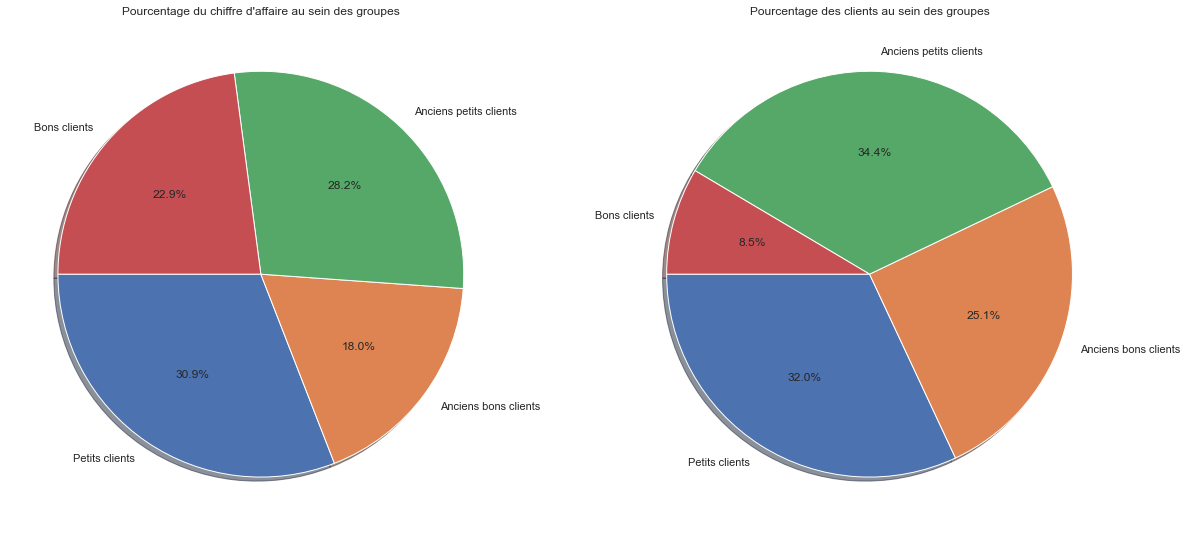

In [22]:
olist.display_customers(
    periods[0],
    [
        "Petits clients",
        "Anciens bons clients",
        "Anciens petits clients",
        "Bons clients"
    ],
    'Monetary'
)

# Analyse de la période des 9 mois

In [23]:
print(f"{new_customers[5]} nouveaux client en 1 mois")

35164 nouveaux client en 1 mois


Text(0.5, 1.0, 'Période de 9 mois')

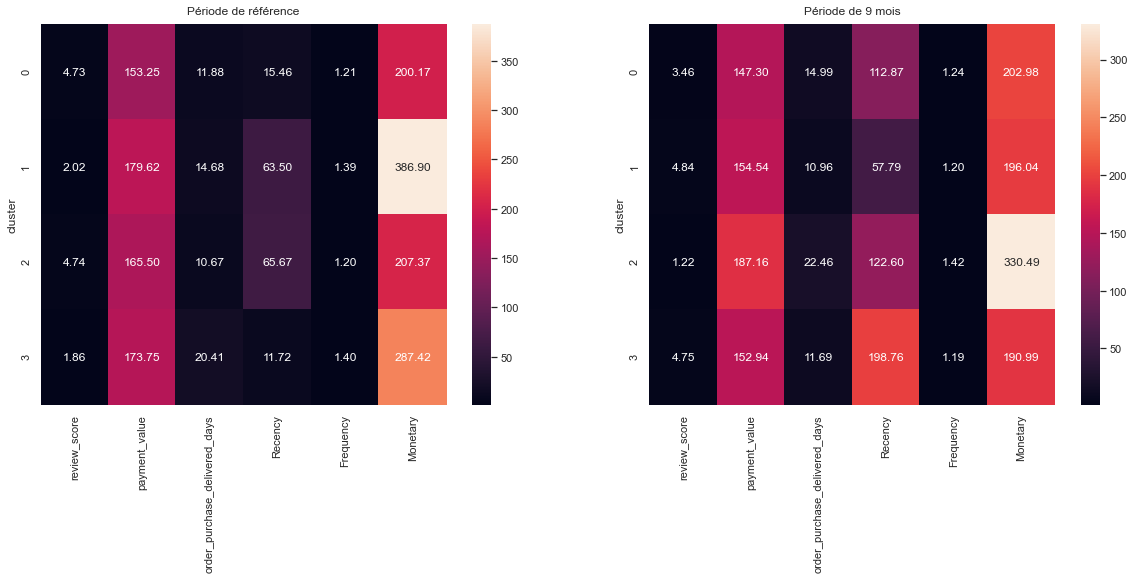

In [24]:
p0 = period_base.groupby('cluster').mean()
p1 = periods[5].groupby('cluster').mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(data=p0.sort_index(), annot=True, fmt='.2f', ax=ax1)
ax1.set_title('Période de référence', pad=10)

sns.heatmap(data=p1, annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Période de 9 mois', pad=10)

L'analyse de la période de 9 mois montre des variations importantes entre les variables. Les clients mécontents deviennent contents, ceux qui avaient les plus gros montants se retrouvent avec les plus faibles montants. Il convient donc de changer de modèle avant cette période pour ne pas fausser les estimations. 

# Conclusion
L'étude de la stabilité du modèle montre qu'au bout de 8 mois, le modèle ne sait plus regrouper les clients correctement. Il est donc nécessaire de revoir ce modèle régulièrement. Nous avons aussi remarqué l'augmentation constante des nouveaux clients.